In [1]:
import numpy as np
import scipy.stats
from scipy.optimize import fsolve, root, curve_fit
import csv
import pandas as pd

def loadcsvfile(filename, path='data/', delimiter=';'):
    """
    Function to read the data from an excel file (.xlsx);
    Converts to and saves as .csv file;
    Loads the data as pandaas DataFrame.
    """
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

def transform(Gy, G, hL, P):
    """
    Coordinate transformation as explained in Fan (2008). Should be used only if P<hL.
    """
    return Gy + 2*G*(hL-P)

def func(x, a):
    """
    Function for linear fit with fixed value of b.
    """
    return a - b*x

def linFit(x, y):
    """
    Linear fit through data.
    Returns:
    a: intercept
    b: slope
    r_value**2: R-squared
    p_value: P-value
    std_err: standard error
    """
    b, a, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return a, b, r_value**2, p_value, std_err

def fixedbFit(func, x, y):
    """
    Linear fit through data with a fixed value for the slope (b).
    Returns:
    a: intercept 
    r_squared: = R-squared
    """
    a = curve_fit(func, x, y)[0][0]
    residuals = y - func(x, *[a])
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return a, r_squared

#constants
g = 9.81

In [2]:
# loading Noordland experiments (M1204) as NL1204
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
NL1204['h0'] = NL1204.am
# Selecting the reference data 1-47
sel = np.arange(47)
NL1204ref = NL1204.iloc[sel]

#selecting the datasets
NL1204D3Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q4 = NL1204ref[(NL1204ref.Q==4e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q6 = NL1204ref[(NL1204ref.Q==6e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q7 = NL1204ref[(NL1204ref.Q==7e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q8 = NL1204ref[(NL1204ref.Q==8e-3) & (NL1204ref.D==3.1e-2)]

NL1204D6Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==6.1e-2) & (~np.isnan(NL1204ref.am))]
NL1204D6Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==6.1e-2)]

reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]
refcol = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k'])

In [3]:
#empty dataframe to fill in coefficient a and other values
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

K = 0.55
b = 1/(2*K)

###Creating linear fits through reference data sets
i = 0 #counter
for NL1204sel in reference_data: #NL1204sel is selected data set
    lam0sel = np.where(NL1204sel.lam!=0)[0] #don't include data points where lam=0 in the fit
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.h0
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    #fit keeping b fixed
    a, rsq = fixedbFit(func, Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
    hL = 1/(2*np.mean(G)*b)

    #linear fit through datapoints
    al, bl, rsql, pl, stdl = linFit(Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
    bl = abs(bl)
    
    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    #coordinate transform if P<hL
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        ap = curve_fit(func, Gyp.iloc[lam0sel], c0c2.iloc[lam0sel])[0][0]
        coeffa.a[i] = ap
        coeffa.b[i] = b
    i += 1

###Constructiong relationship coefficient a with P/hL
xfit = np.linspace(-20,20,1000) #x-axis is P/hL-1
intercept, slope, r_squared, p_value, std_err = linFit(coeffa.P/coeffa.hL-1, coeffa.a)
afit = slope*xfit+intercept

###Comparing observed values to computed values
c0c2comp_all = np.array([]) #empty array to save all computed values of c0/c2
c0c2obs_all = np.array([]) #... observed ...

i = 0
for NL1204sel in reference_data:
    c0c2obs = 1 - NL1204sel.lam
    G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
    P = NL1204sel.D/2
    y = P - NL1204sel.h0

    hL = K/G
    acomp = np.interp(P/hL-1,xfit,afit) #computed value of coefficient a from relationship with P/hL
    c0c2comp = acomp - b*G*y
    ## if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
    c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
    
    ## forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
    c0c2comp[c0c2comp<0] = 0
    c0c2comp[c0c2comp>1] = 1
    
    c0c2obs_all = np.append(c0c2obs_all, c0c2obs[c0c2comp<1])
    c0c2comp_all = np.append(c0c2comp_all, c0c2comp[c0c2comp<1])
    i+=1

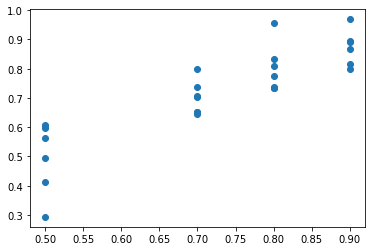

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(c0c2obs_all, c0c2comp_all, 'o')

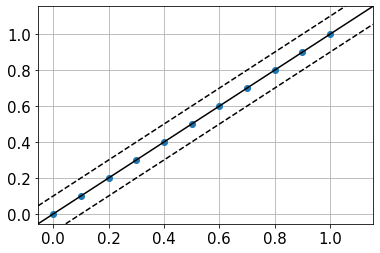

In [73]:
x = np.array([.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
y = np.array([.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

plt.plot(x,y,'o')
plt.gca().axline([1,1],slope=1, color='k')
plt.gca().axline([1,1.1],slope=1, color='k', linestyle='--')
plt.gca().axline([1.1,1],slope=1, color='k', linestyle='--')
plt.grid()